# Damped harmonic oscillator

## x random output nodes

Formula of damped harmonic oscillator

$$ x(t) = A_0 e^{\frac{-b}{2t}} \cos(\sqrt{\kappa - \frac{b^2}{4}} t + \delta_0) $$

$$ A_0 = 1, \\
\delta_0 = 0, \\
b \in [0.5, 1], \\
\kappa \in [5, 10]. $$

for 100000 random values of $b$ and $\kappa$.

We train reconstructing with x time points. To do this, we ask x questions at a random time $t_{meas}$ between 0s and 5s. This leads to x answer as output.

## Imports

In [1]:
from google.colab import drive

drive.mount('/content/drive')

path = "/content/drive/My Drive/PhD year 1/BETA oscillator/"

import sys
sys.path.insert(0, path) # To import module scinet

Mounted at /content/drive


In [2]:
!pip install wandb
from scinet import *
import scinet.ed_oscillator_random as edo

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
     |████████████████████████████████| 140 kB 43.5 MB/s 
     |████████████████████████████████| 97 kB 6.6 MB/s 
     |████████████████████████████████| 180 kB 43.3 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=073516ac91912854904b540c55db4bf4da7ea77f808220a91858c5acae9025d1
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=57fd89be15167d31249369ac96a1d068465b8a3ba906dbb1217762a54ba07c6d
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


## Data creation and loading

In [3]:
# Create data
create_data = False
output_nodes_list = [1, 2, 5, 10, 25, 50]
if create_data:
    for output_nodes in output_nodes_list:
        edo.oscillator_data(N=100000, output_nodes=output_nodes, seed=0,
                            fileName=f'oscillator random/oscillator_{output_nodes}');
        print(f"Created data for {output_nodes} output nodes!")
else:
    print("Data already created!")

Data already created!


In [4]:
# Load data
output_nodes = 2
td, vd, ts, vs, proj = dl.load(5, f'oscillator random/oscillator_{output_nodes}')
print(f"Train: {td[0].shape[0]} samples, validation: {vd[0].shape[0]} samples\n")
print(f"Shapes (x_in, t_meas, x_out) = {[td[i].shape for i in [0, 1, 2]]}")
print(f"Shapes (A_0, delta, b, k) = {[ts[:, i].shape for i in [0, 1, 2, 3]]}")

Train: 95000 samples, validation: 5000 samples

Shapes (x_in, t_meas, x_out) = [(95000, 50), (95000, 2), (95000, 2)]
Shapes (A_0, delta, b, k) = [(95000,), (95000,), (95000,), (95000,)]


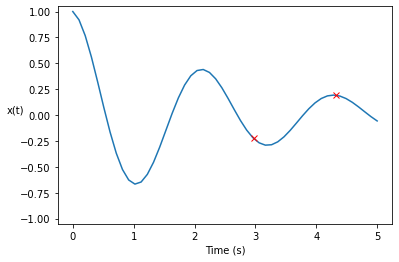

(A_0, delta, b, k) = [1.0, 0.0, 0.7644474598764522, 8.590930161584707]

t_meas = [2.97010615 4.32660567]


In [5]:
# Plot the first training sample td[:][0]
import matplotlib.pyplot as plt
import numpy as np

t_sample = np.linspace(0, 5, 50)
sample_idx = 11
x_in = td[0][sample_idx]
t_meas = td[1][sample_idx]
x_out = td[2][sample_idx]

plt.plot(t_sample, x_in, label='x_in');
plt.plot(t_meas, x_out, 'rx', label='x_out')
plt.xlabel('Time (s)')
plt.ylabel('x(t)', rotation=0)
plt.ylim([-1.05, 1.05])
#plt.legend()
plt.show()

print(f"(A_0, delta, b, k) = {[ts[sample_idx, i] for i in [0, 1, 2, 3]]}\n")
print(f"t_meas = {t_meas}")

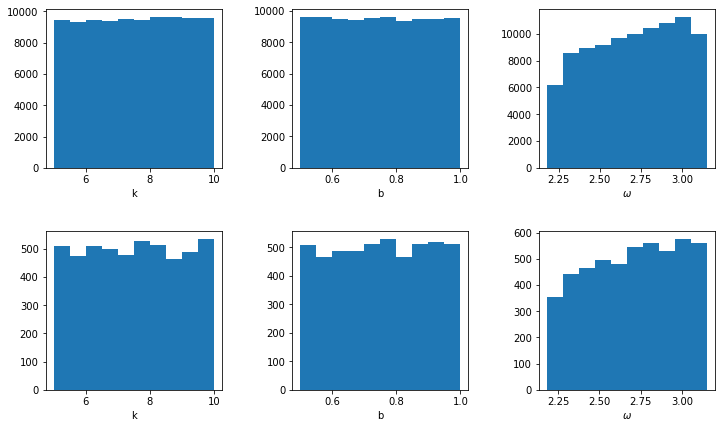

In [6]:
# Plot distributions of k, b and omega

plt.figure(figsize=(12, 7))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for row, data in enumerate([ts, vs]):
    k = data[:, 3]
    b = data[:, 2]
    omega = np.sqrt(k - (b**2/4))
    
    # Plot k hist
    plt.subplot(2, 3, 1 + row*3)
    plt.hist(k)
    plt.xlabel('k')
    
    # Plot b hist
    plt.subplot(2, 3, 2 + row*3)
    plt.hist(b)
    plt.xlabel('b')
    
    # Plot omega hist
    plt.subplot(2, 3, 3 + row*3)
    plt.hist(omega)
    plt.xlabel(r'$\omega$')
    
plt.show()

## Create and train neural network

In [ ]:
import wandb
wandb.login()

In [ ]:
import tensorflow as tf

# create and train network
seed_list = [0]
output_nodes_list = [1, 2, 5, 10, 25, 50]

for seed in seed_list: 
    for output_nodes in output_nodes_list:
        print(f"Training network with {output_nodes} output nodes...")
        run = wandb.init(project="Oscillator random output nodes swish",
                         config={
                             "output_nodes": output_nodes,
                             "latent_dim": 10,
                             "epochs": 150, 
                             "beta": 0.001, 
                             "seed": seed})
        config = wandb.config

        td, vd, ts, vs, proj = dl.load(5, f'oscillator random/oscillator_{config.output_nodes}')

        net = nn.Network(input_size=50, latent_size=10, 
                         input2_size=config.output_nodes, output_size=config.output_nodes,
                         seed=config.seed, activation=tf.keras.activations.swish, 
                         wandblog=True)

        #def train(epoch_num, batch_size, learning_rate, training_data, validation_data, **kwargs)
        net.train(config.epochs, 250, 0.001, td, vd)
        net.save(f'oscillator random swish/oscillator_{config.output_nodes}_seed_{config.seed}')

    # end wandb run
    run.join()

Training network with 1 output nodes...


  0%|          | 0/150 [00:00<?, ?it/s]

Working on epoch 10...
Finished epoch 10!

Working on epoch 20...
Finished epoch 20!

Working on epoch 30...
Finished epoch 30!

Working on epoch 40...
Finished epoch 40!

Working on epoch 50...
Finished epoch 50!

Working on epoch 60...
Finished epoch 60!

Working on epoch 70...
Finished epoch 70!

Working on epoch 80...
Finished epoch 80!

Working on epoch 90...
Finished epoch 90!

Working on epoch 100...
Finished epoch 100!

Working on epoch 110...
Finished epoch 110!

Working on epoch 120...
Finished epoch 120!

Working on epoch 130...
Finished epoch 130!

Working on epoch 140...
Finished epoch 140!

Working on epoch 150...
Finished epoch 150!

Saved network to file oscillator random swish/oscillator_1_seed_0
Training network with 2 output nodes...


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
kl_divergence_train,▃▁▃▅▇▇▆▇▇▇▇▆▆█▇▇▇▇▇▇▇▇▇█▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▆
mae_test,█▆▄▂▂▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recon_loss_train,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_loss_train,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,150
kl_divergence_train,2.53667
mae_test,0.00989
recon_loss_train,0.00016
total_loss_train,0.0027


  0%|          | 0/150 [00:00<?, ?it/s]

Working on epoch 10...
Finished epoch 10!

Working on epoch 20...
Finished epoch 20!

Working on epoch 30...
Finished epoch 30!

Working on epoch 40...
Finished epoch 40!

Working on epoch 50...
Finished epoch 50!

Working on epoch 60...
Finished epoch 60!

Working on epoch 70...
Finished epoch 70!

Working on epoch 80...
Finished epoch 80!

Working on epoch 90...
Finished epoch 90!

Working on epoch 100...
Finished epoch 100!

Working on epoch 110...
Finished epoch 110!

Working on epoch 120...
Finished epoch 120!

Working on epoch 130...
Finished epoch 130!

Working on epoch 140...
Finished epoch 140!

Working on epoch 150...
Finished epoch 150!

Saved network to file oscillator random swish/oscillator_2_seed_0
Training network with 5 output nodes...


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
kl_divergence_train,▁▅▇▆▇▇▇███████▇█████████████████████████
mae_test,█▅▄▃▃▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recon_loss_train,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_loss_train,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,150
kl_divergence_train,2.57707
mae_test,0.01329
recon_loss_train,0.0003
total_loss_train,0.00288


  0%|          | 0/150 [00:00<?, ?it/s]

Working on epoch 10...
Finished epoch 10!

Working on epoch 20...
Finished epoch 20!

Working on epoch 30...
Finished epoch 30!

Working on epoch 40...
Finished epoch 40!

Working on epoch 50...
Finished epoch 50!

Working on epoch 60...
Finished epoch 60!

Working on epoch 70...
Finished epoch 70!

Working on epoch 80...
Finished epoch 80!

Working on epoch 90...
Finished epoch 90!

Working on epoch 100...
Finished epoch 100!

Working on epoch 110...
Finished epoch 110!

Working on epoch 120...
Finished epoch 120!

Working on epoch 130...
Finished epoch 130!

Working on epoch 140...
Finished epoch 140!

Working on epoch 150...
Finished epoch 150!

Saved network to file oscillator random swish/oscillator_5_seed_0
Training network with 10 output nodes...


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
kl_divergence_train,▁▂▅▆▆▆▆▆▇▇▇▇████████████████████████████
mae_test,█▆▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recon_loss_train,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_loss_train,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,150
kl_divergence_train,2.62564
mae_test,0.01474
recon_loss_train,0.00036
total_loss_train,0.00299


  0%|          | 0/150 [00:00<?, ?it/s]

Working on epoch 10...
Finished epoch 10!

Working on epoch 20...
Finished epoch 20!

Working on epoch 30...
Finished epoch 30!

Working on epoch 40...
Finished epoch 40!

Working on epoch 50...
Finished epoch 50!

Working on epoch 60...
Finished epoch 60!

Working on epoch 70...
Finished epoch 70!

Working on epoch 80...
Finished epoch 80!

Working on epoch 90...
Finished epoch 90!

Working on epoch 100...
Finished epoch 100!

Working on epoch 110...
Finished epoch 110!

Working on epoch 120...
Finished epoch 120!

Working on epoch 130...
Finished epoch 130!

Working on epoch 140...
Finished epoch 140!

Working on epoch 150...
Finished epoch 150!

Saved network to file oscillator random swish/oscillator_10_seed_0
Training network with 25 output nodes...


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
kl_divergence_train,▁▁▁▂▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█████████████████
mae_test,█▇▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recon_loss_train,█▆▄▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_loss_train,█▆▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,150
kl_divergence_train,2.58839
mae_test,0.02222
recon_loss_train,0.00082
total_loss_train,0.00341


  0%|          | 0/150 [00:00<?, ?it/s]

Working on epoch 10...
Finished epoch 10!

Working on epoch 20...
Finished epoch 20!

Working on epoch 30...
Finished epoch 30!

Working on epoch 40...
Finished epoch 40!

Working on epoch 50...
Finished epoch 50!

Working on epoch 60...
Finished epoch 60!

Working on epoch 70...
Finished epoch 70!

Working on epoch 80...
Finished epoch 80!

Working on epoch 90...
Finished epoch 90!

Working on epoch 100...
Finished epoch 100!

Working on epoch 110...
Finished epoch 110!

Working on epoch 120...
Finished epoch 120!

Working on epoch 130...
Finished epoch 130!

Working on epoch 140...
Finished epoch 140!

Working on epoch 150...
Finished epoch 150!

Saved network to file oscillator random swish/oscillator_25_seed_0
Training network with 50 output nodes...


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
kl_divergence_train,▁▁▁▁▁▁▁▂▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇████████
mae_test,████▇▇▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
recon_loss_train,███▇▇▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_loss_train,███▇▇▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,150
kl_divergence_train,1.75597
mae_test,0.09134
recon_loss_train,0.01471
total_loss_train,0.01646


  0%|          | 0/150 [00:00<?, ?it/s]

Working on epoch 10...
Finished epoch 10!

Working on epoch 20...
Finished epoch 20!

Working on epoch 30...
Finished epoch 30!

Working on epoch 40...
Finished epoch 40!

Working on epoch 50...
Finished epoch 50!

Working on epoch 60...
Finished epoch 60!

Working on epoch 70...
Finished epoch 70!

Working on epoch 80...
Finished epoch 80!

Working on epoch 90...
Finished epoch 90!

Working on epoch 100...
Finished epoch 100!

Working on epoch 110...
Finished epoch 110!

Working on epoch 120...
Finished epoch 120!

Working on epoch 130...
Finished epoch 130!

Working on epoch 140...
Finished epoch 140!

Working on epoch 150...
Finished epoch 150!

Saved network to file oscillator random swish/oscillator_50_seed_0


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
kl_divergence_train,▂▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████████
mae_test,██████▇▇▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁
recon_loss_train,█████▇▇▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_loss_train,█████▇▇▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,150
kl_divergence_train,0.69627
mae_test,0.21638
recon_loss_train,0.0814
total_loss_train,0.0821


## Show predictions

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/PhD year 1/BETA oscillator/tf_save/oscillator random swish/oscillator_2_seed_0.ckpt
Loaded network from file oscillator random swish/oscillator_2_seed_0
MAE on validation set: 0.013294136460387025
t_meas: [2.36353474 1.84521328], x_out: [0.27624233 0.22066754]
t_meas: [0.5952163  0.32059856], x_out: [-0.19865037  0.48653606]
t_meas: [2.23372842 0.62331221], x_out: [ 0.51615644 -0.08875763]
t_meas: [4.73705873 1.84559731], x_out: [ 0.12662352 -0.00455579]
t_meas: [9.89058852e-01 9.06390179e-04], x_out: [-0.50292641  0.99969093]
t_meas: [2.91899743 0.32773993], x_out: [-0.21268622  0.46631245]


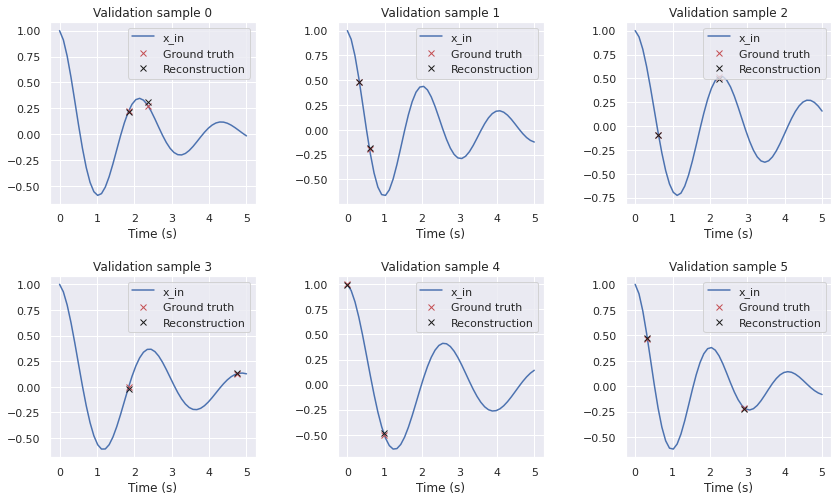

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

output_nodes = 2
td, vd, ts, vs, proj = dl.load(5, f'oscillator random/oscillator_{output_nodes}')

# Load network
net = nn.Network(input_size=50, latent_size=10, 
                 input2_size=output_nodes, output_size=output_nodes,
                 seed=0, activation=tf.keras.activations.swish, #tf.nn.elu
                 wandblog=True, load_file=f"oscillator random swish/oscillator_{output_nodes}_seed_0")

t_sample = np.linspace(0, 5, 50)
x_pred = net.run(vd, layer=net.output)
mae = tf.keras.losses.mean_absolute_error(x_pred.reshape(-1), vd[2].reshape(-1))
print(f"MAE on validation set: {mae}")

plt.figure(figsize=(14, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for i, sample_idx in enumerate([0, 1, 2, 3, 4, 5]):
    
    x_in = vd[0][sample_idx]
    t_meas = vd[1][sample_idx]
    x_out = vd[2][sample_idx]
    
    b = vs[sample_idx][2]
    k = vs[sample_idx][3]
        
    plt.subplot(2, 3, i+1)
    plt.plot(t_sample, x_in, label='x_in');
    plt.plot(t_meas, x_out, 'rx', label='Ground truth')
    print(f"t_meas: {t_meas}, x_out: {x_out}")
    plt.plot(t_meas, x_pred[sample_idx], 'kx', label='Reconstruction')
    plt.legend()
    plt.xlabel('Time (s)')
    plt.title(f"Validation sample {sample_idx}")
    
plt.show()

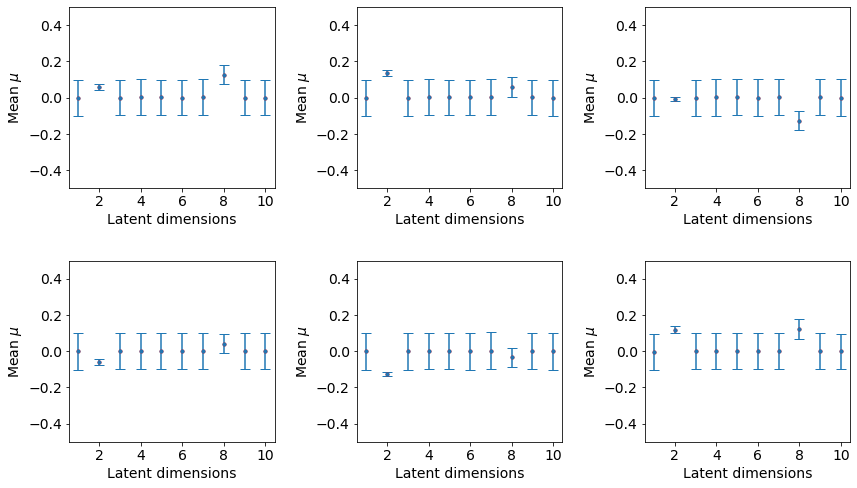

In [8]:
# Plot latent dimensions of above reconstructions

mu_all, logvar_all, z_all = net.run(vd, layer=net.mu), tf.exp(net.run(vd, layer=net.log_sigma)), net.run(vd, layer=net.mu_sample)

plt.figure(figsize=(14, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for i, sample_idx in enumerate([0, 1, 2, 3, 4, 5]):
    
    mu = mu_all[sample_idx]
    logvar = logvar_all[sample_idx]
    z = z_all[sample_idx]
    
    plt.subplot(2, 3, i+1)
    plt.errorbar([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], mu, 
                 yerr=logvar, marker=".", ls=" ", capsize=5)
    plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], z, 'r.')
    
    plt.xlabel("Latent dimensions", fontsize=14)
    plt.ylabel("Mean $\mu$", fontsize=14)
    plt.ylim([-0.5, 0.5])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
plt.show()

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/PhD year 1/BETA oscillator/tf_save/oscillator random swish/oscillator_10_seed_0.ckpt
Loaded network from file oscillator random swish/oscillator_10_seed_0
Latent dimension 8 is active!
Latent dimension 10 is active!
There are 2 active latent dimensions!


Pearson correlation dimension 8 with k: -0.0145
Pearson correlation dimension 10 with k: 0.9961


Pearson correlation dimension 8 with b: 0.9964
Pearson correlation dimension 10 with b: -0.0206


Pearson correlation dimension 8 with omega: -0.0515
Pearson correlation dimension 10 with omega: 0.9988




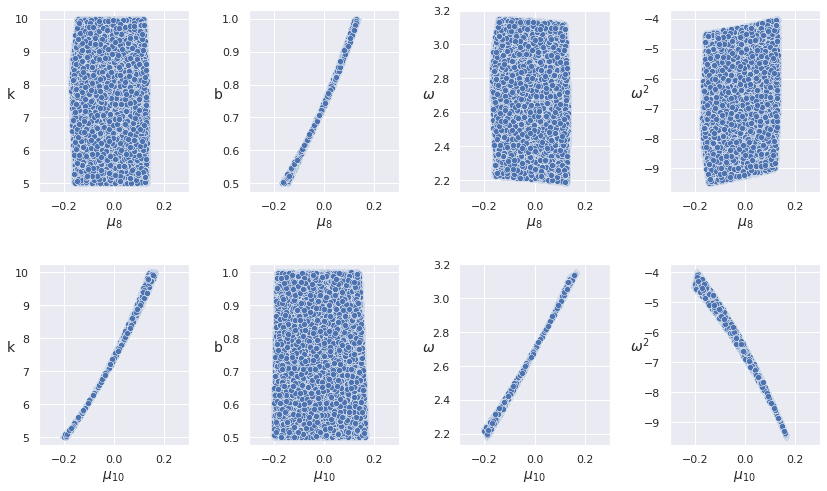

In [21]:
# Plot the occupied latent dimensions 
import seaborn as sns
sns.set(style="darkgrid")
from scipy.stats import pearsonr

output_nodes = 10
# Load data
td, vd, ts, vs, proj = dl.load(5, f'oscillator random/oscillator_{output_nodes}')

k_train = ts[:, 3]
b_train = ts[:, 2]
k_val = vs[:, 3]
b_val = vs[:, 2]

omega_train = np.sqrt(k_train - (b_train**2/4))
omega_val = np.sqrt(k_val - (b_val**2/4))

omega_square_train = np.sqrt(4*k_train - 4*omega_train**2) - k_train
omega_square_val = k_val - (b_val**2/4)

# Load network
net = nn.Network(input_size=50, latent_size=10, 
                 input2_size=output_nodes, output_size=output_nodes,
                 seed=0, activation=tf.keras.activations.swish, #tf.nn.elu
                 wandblog=True, load_file=f"oscillator random swish/oscillator_{output_nodes}_seed_0")

mu_train, logvar_train, z_train = net.run(td, layer=net.mu), tf.exp(net.run(td, layer=net.log_sigma)), net.run(td, layer=net.mu_sample)
mu_val, logvar_val, z_val = net.run(vd, layer=net.mu), tf.exp(net.run(vd, layer=net.log_sigma)), net.run(vd, layer=net.mu_sample)


# Compute Activated Units (AU) using cov(mu)
active_dims = []
treshold = 0.005 # was 0.01 in other experiment
for i in range(10):
    cov_mu = np.cov(z_train[:, i])
    if cov_mu > treshold:
        print(f"Latent dimension {i+1} is active!")
        active_dims.append(i + 1) 
print(f"There are {len(active_dims)} active latent dimensions!")
    
# Create scatterplots
fig, axs = plt.subplots(2, 4, figsize=(14, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for row, par in enumerate([k_train, b_train, omega_train, omega_square_train]):
    print("\n")
    for i in range(2):
        if len(active_dims) == 2:
            dim = active_dims
        else:
            dim = [1, 6]
        ax = axs.reshape(-1)[row + i*4]
        sns.scatterplot(x=z_train[:, dim[i] - 1], y=par, palette="RdBu",  ax=ax)
        ax.set_xlim([-0.3, 0.3])
        
        # Set x label
        if dim[i] == 10:
            ax.set_xlabel(r"$\mu_{10}$", fontsize=14)
        else:
            ax.set_xlabel(f"$\mu_{dim[i]}$", fontsize=14)

        # Compute correlation with each dimension
        corr, p = pearsonr(z_train[:, dim[i] - 1], par)
            
        # Set y label
        if row == 0:
            ax.set_ylabel("k", rotation='horizontal', fontsize=14)
            print(f"Pearson correlation dimension {dim[i]} with k: {corr:.4f}")  
        elif row == 1:
            ax.set_ylabel("b", rotation='horizontal', fontsize=14)
            print(f"Pearson correlation dimension {dim[i]} with b: {corr:.4f}")  
        elif row == 2:
            ax.set_ylabel(r"$\omega$", rotation='horizontal', fontsize=14)
            print(f"Pearson correlation dimension {dim[i]} with omega: {corr:.4f}") 
        elif row == 3:
            ax.set_ylabel(r"$\omega^2$", rotation='horizontal', fontsize=14)

fig.show()

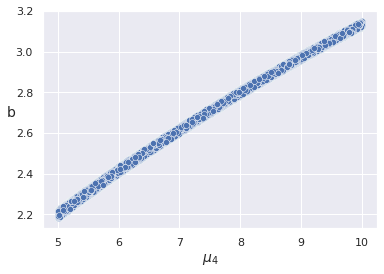

In [ ]:
sns.scatterplot(x=k_train, y=omega_train, palette="RdBu")

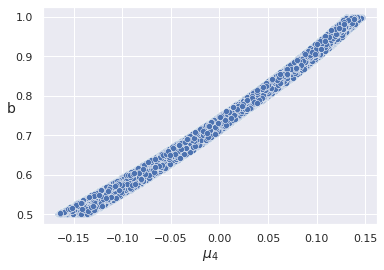

In [ ]:
sns.scatterplot(x=z_train[:, 4 - 1], y=b_train)
plt.xlabel(r'$\mu_4$', fontsize=14);
plt.ylabel("b", rotation='horizontal', fontsize=14);

62
[-2.7529895e-05  7.2803348e-05  8.2407147e-05  8.5495412e-06
  6.0960650e-05 -6.9215894e-05  2.5838614e-05  6.5214932e-05
 -3.8594007e-06  3.4920871e-05 -1.3761222e-05 -3.1359494e-05
  4.5157969e-05  9.9167228e-05 -8.4381551e-05 -2.7183443e-05
 -4.1533262e-05  4.6186149e-05 -6.7874789e-05  2.7429312e-05
  6.1374158e-05 -4.9538910e-05 -6.8806112e-05  6.4145774e-05
 -3.1445175e-05  2.7906150e-05 -6.7219138e-05 -3.5166740e-06
  5.7201833e-05  3.1407923e-05  3.0472875e-06  5.3994358e-05
 -7.4133277e-07 -6.7301095e-05  4.7460198e-05 -4.1246414e-05
  2.5242567e-05  3.8091093e-05 -1.3943762e-05 -3.7699938e-05
  4.3772161e-05 -4.8317015e-06 -9.2327595e-05 -1.1835247e-05
 -9.2983246e-05  3.3896416e-05 -7.5630844e-05 -4.7583133e-05
  7.3555857e-05  8.7305903e-05  7.8465790e-05  3.4123659e-06
 -5.4713339e-05 -4.7646463e-06 -5.1252544e-05 -2.3059547e-05
 -8.0652535e-06  7.0042908e-05 -3.5002828e-05 -2.2299588e-05
  7.3712319e-05 -7.8849494e-05]
[44 42 14 61 46  5 22 18 33 26 52 54 21 47 16 35 3

Text(0, 0.5, '$\\omega$')

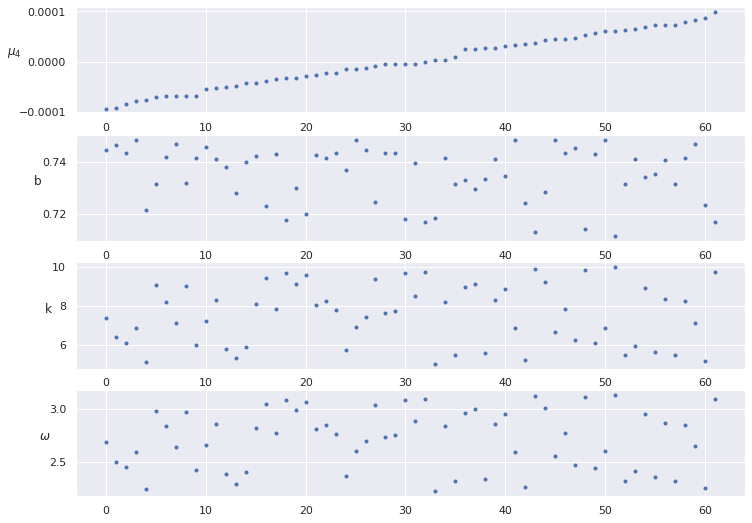

In [ ]:
indices = [i for i in range(len(z_train[:, 4 - 1])) if -0.0001 < z_train[:, 4 - 1][i] < 0.0001]
print(len(indices))
print(z_train[:, 4 - 1][indices])
sorted_indices = np.argsort(z_train[:, 4 - 1][indices])
print(sorted_indices)
plt.figure(figsize=(12, 9))
plt.subplot(4, 1, 1)
plt.plot(z_train[:, 4 - 1][indices][sorted_indices], '.');
plt.ylabel(r"$\mu_{4}$", rotation='horizontal')
plt.subplot(4, 1, 2)
plt.plot(b_train[indices][sorted_indices], '.')
plt.ylabel("b", rotation='horizontal')
plt.subplot(4, 1, 3)
plt.plot(k_train[indices][sorted_indices], '.')
plt.ylabel("k", rotation='horizontal')
plt.subplot(4, 1, 4)
plt.plot(omega_train[indices][sorted_indices], '.')
plt.ylabel(r"$\omega$", rotation='horizontal')

In [ ]:
def save_correlation(output_nodes=1):
  print(f"k shape: {k_train.shape}")
  print(f"b shape: {b_train.shape}")
  print(f"mean shape: {z_train.shape}")
  correlation = np.concatenate([k_train.reshape(-1, 1), b_train.reshape(-1, 1), z_train], axis=1)
  print(f"correlation shape: {correlation.shape}")
  np.save(path + f"correlation_random_output_nodes={output_nodes}.npy",
          correlation)

save_correlation(output_nodes=1)

k shape: (95000,)
b shape: (95000,)
mean shape: (95000, 10)
correlation shape: (95000, 12)


In [ ]:
# Save correlations for figures
def save_correlation(model, specs, experiment_path):
  """Creates a scatter plot between f and the mean of each dimension. Also 
  computes the spearman correlation between f and each of the dimensions."""
  # Select train or test data
  mean, _ = model.encode(y_in_split['test'].reshape(-1, 200))
  f = f_split['test'].reshape(-1)
  A = A_split['test'].reshape(-1)
  
  # Save correlation
  print(f"f shape: {f.shape}")
  print(f"A shape: {A.shape}")
  print(f"mean shape: {mean.shape}")
  correlation = np.concatenate([f.reshape(-1, 1), A.reshape(-1, 1), mean], axis=1)
  print(f"correlation shape: {correlation.shape}")
  np.save(path + "gifs/" + experiment_path + f"correlation_fixed_output_nodes={specs['output nodes']}",
          correlation)

  # Create scatterplots
  fig, axs = plt.subplots(4,5, figsize=(12, 12))
  plt.subplots_adjust(hspace=0.4, wspace=0.4)

  # plots with f
  for i in range(10):
    ax = axs.reshape(-1)[i]
    sns.scatterplot(x=mean[:, i], y=f, palette="RdBu",  ax=ax)
    ax.set_xlim([-6, 6])

    # To get 10 in underscore
    if (i + 1) != 10:
      ax.set_xlabel(f"$\mu_{i+1}$")
    elif (i+1) == 10:
      ax.set_xlabel(r"$\mu_{10}$")

    ax.set_ylabel("f", rotation='horizontal')

  fig.show()

  # plots with A
  for i in range(10):
    ax = axs.reshape(-1)[i+10]
    sns.scatterplot(x=mean[:, i], y=A, palette="RdBu",  ax=ax)
    ax.set_xlim([-6, 6])

    # To get 10 in underscore
    if (i + 1) != 10:
      ax.set_xlabel(f"$\mu_{i+1}$")
    elif (i+1) == 10:
      ax.set_xlabel(r"$\mu_{10}$")

    ax.set_ylabel("A", rotation='horizontal')

  fig.show()

  # Compute Activated Units (AU) using cov(mu)
  active_dims = 0
  treshold = 0.01
  for i in range(10):
    cov_mu = np.cov(mean[:, i])
    if cov_mu > treshold:
      print(f"Latent dimension {i+1} is active!")
      active_dims += 1
  print(f"There are {active_dims} active latent dimensions!")

for model_idx in [5, 11, 17, 29, 35, 41, 47]:
  model, specs = get_model(metadata.loc[model_idx], experiment_path="x output nodes 2pi batch 250 100000 samples 235 fixed points/")
  save_correlation(model, specs, experiment_path="x output nodes 2pi batch 250 100000 samples 235 fixed points/")

## Active Units (AU) and simplifying table

In [27]:
import pandas as pd

# Get row in table for net with given output nodes
def get_row(output_nodes, seed, activation='swish'):

    # Load data
    td, vd, ts, vs, proj = dl.load(5, f'oscillator random/oscillator_{output_nodes}')

    k_train = ts[:, 3]
    b_train = ts[:, 2]
    k_val = vs[:, 3]
    b_val = vs[:, 2]

    omega_train = np.sqrt(k_train - (b_train**2/4))
    omega_val = np.sqrt(k_val - (b_val**2/4))

    # Load network
    if activation=='swish':
      act_fun = tf.keras.activations.swish
    elif activation=='ELU':
      act_fun = tf.nn.elu
    else:
      print(f'Activation {activation} is not valid')
      return

    net = nn.Network(input_size=50, latent_size=10, 
                     input2_size=output_nodes, output_size=output_nodes,
                     seed=0, activation=act_fun, wandblog=True, 
                     load_file=f"oscillator random {activation}/oscillator_{output_nodes}_seed_{seed}");

    # Compute latent representation
    mu_train, logvar_train, z_train = net.run(td, layer=net.mu), tf.exp(net.run(td, layer=net.log_sigma)), net.run(td, layer=net.mu_sample)
    mu_val, logvar_val, z_val = net.run(vd, layer=net.mu), tf.exp(net.run(vd, layer=net.log_sigma)), net.run(vd, layer=net.mu_sample)

    # Compute Activated Units (AU) using cov(mu)
    active_dims = 0
    treshold = 0.005 # was 0.01 in other experiment
    for i in range(10):
        cov_mu = np.cov(z_train[:, i])
        if cov_mu > treshold:
            print(f"Latent dimension {i+1} is active!")
            active_dims += 1
    print(f"There are {active_dims} active latent dimensions!")
    
    # Compute test MAE
    x_pred = net.run(vd, layer=net.output)
    mae_test = tf.keras.losses.mean_absolute_error(x_pred.reshape(-1), vd[2].reshape(-1))
    
    # Compute KL div
    kl_div = net.run(vd, layer=net.kl_loss)

    # Compute Pearson correlations
    dim_k = {1: 1, 2: 4, 5: 2, 10: 10, 25: 1, 50: 6}
    corr_k, p_k = pearsonr(z_train[:, dim_k[output_nodes] - 1], k_train)
    corr_omega, p_omega = pearsonr(z_train[:, dim_k[output_nodes] - 1], omega_train)
    
    # Put data in panda row
    row = pd.Series(index=['Output nodes', 'Seed', 'Test MAE', 
                           'KL div', 'Active Units', 'Pearson k', 'Pearson omega'],
                    data=[int(output_nodes), seed, mae_test.numpy(), 
                          kl_div, int(active_dims), corr_k, corr_omega])
    
    return row

res = get_row(output_nodes=10, seed=0, activation='swish')
print(res)

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/PhD year 1/BETA oscillator/tf_save/oscillator random swish/oscillator_10_seed_0.ckpt
Loaded network from file oscillator random swish/oscillator_10_seed_0
Latent dimension 8 is active!
Latent dimension 10 is active!
There are 2 active latent dimensions!
Output nodes     10.000000
Seed              0.000000
Test MAE          0.022216
KL div            2.587556
Active Units      2.000000
Pearson k         0.996064
Pearson omega     0.998758
dtype: float64


In [28]:
# Create simple table from different rows
def create_simple_table():
    simple_table = pd.DataFrame(columns=['Output nodes', 'Seed', 'Test MAE',
                                         'KL div', 'Active Units'])
    simple_table.to_csv(io.data_path + 'simple_table_random_swish.csv')

def add_row(output_nodes_list):
    simple_table = load_simple_table()

    for output_nodes in output_nodes_list:
        for seed in [0]:
            row = get_row(output_nodes=output_nodes, seed=seed, activation='swish')
            simple_table = simple_table.append(row, ignore_index=True)
    simple_table.to_csv(io.data_path + 'simple_table_random_swish.csv')
    return simple_table

def load_simple_table():
    simple_table = pd.read_csv(io.data_path + 'simple_table_random_swish.csv', index_col=0)
    return simple_table

create_simple_table()
simple_table = add_row(output_nodes_list=[1, 2, 5, 10, 25, 50])
simple_table

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/PhD year 1/BETA oscillator/tf_save/oscillator random swish/oscillator_1_seed_0.ckpt
Loaded network from file oscillator random swish/oscillator_1_seed_0
Latent dimension 1 is active!
Latent dimension 3 is active!
There are 2 active latent dimensions!
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/PhD year 1/BETA oscillator/tf_save/oscillator random swish/oscillator_2_seed_0.ckpt
Loaded network from file oscillator random swish/oscillator_2_seed_0
Latent dimension 1 is active!
Latent dimension 4 is active!
There are 2 active latent dimensions!
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/PhD year 1/BETA oscillator/tf_save/oscillator random swish/oscillator_5_seed_0.ckpt
Loaded network from file oscillator random swish/oscillator_5_seed_0
Latent dimension 2 is active!
Latent dimension 8 is active!
There are 2 active latent dimensions!
INFO:tensorflow:Restoring parameters from /conten

,Output nodes,Seed,Test MAE,KL div,Active Units,Pearson k,Pearson omega
0,1.0,0.0,0.009892,2.535856,2.0,-0.997832,-0.998828
1,2.0,0.0,0.013294,2.575289,2.0,0.998278,0.999248
2,5.0,0.0,0.014738,2.625756,2.0,0.998167,0.999293
3,10.0,0.0,0.022216,2.587556,2.0,0.996064,0.998758
4,25.0,0.0,0.091339,1.758026,1.0,0.990912,0.995089
5,50.0,0.0,0.216378,0.697293,1.0,0.992371,0.994198


In [29]:
# Load simple table
simple_table = pd.read_csv(io.data_path + 'simple_table_random_swish.csv', index_col=0)
simple_table

,Output nodes,Seed,Test MAE,KL div,Active Units,Pearson k,Pearson omega
0,1.0,0.0,0.009892,2.535856,2.0,-0.997832,-0.998828
1,2.0,0.0,0.013294,2.575289,2.0,0.998278,0.999248
2,5.0,0.0,0.014738,2.625756,2.0,0.998167,0.999293
3,10.0,0.0,0.022216,2.587556,2.0,0.996064,0.998758
4,25.0,0.0,0.091339,1.758026,1.0,0.990912,0.995089
5,50.0,0.0,0.216378,0.697293,1.0,0.992371,0.994198


In [30]:
simple_table[simple_table['Seed']==0].to_latex(index=False)

'\\begin{tabular}{rrrrrrr}\n\\toprule\n Output nodes &  Seed &  Test MAE &    KL div &  Active Units &  Pearson k &  Pearson omega \\\\\n\\midrule\n          1.0 &   0.0 &  0.009892 &  2.535856 &           2.0 &  -0.997832 &      -0.998828 \\\\\n          2.0 &   0.0 &  0.013294 &  2.575289 &           2.0 &   0.998278 &       0.999248 \\\\\n          5.0 &   0.0 &  0.014738 &  2.625756 &           2.0 &   0.998167 &       0.999293 \\\\\n         10.0 &   0.0 &  0.022216 &  2.587556 &           2.0 &   0.996064 &       0.998758 \\\\\n         25.0 &   0.0 &  0.091339 &  1.758026 &           1.0 &   0.990912 &       0.995089 \\\\\n         50.0 &   0.0 &  0.216378 &  0.697293 &           1.0 &   0.992371 &       0.994198 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
# Reconstruct full time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

t_sample = np.linspace(0, 5, 50)
output_nodes = 25
td, vd, ts, vs, proj = dl.load(5, f'oscillator random/oscillator_{output_nodes}')
net = nn.Network(input_size=50, latent_size=10, 
                 input2_size=output_nodes, output_size=output_nodes,
                 seed=0, load_file=f"oscillator_{output_nodes}");

# Make samples like vd for j samples, 50 rows for each data point t in [0, 5]
x_in_list = list()
t_meas_list = list()
x_out_list = list()

for j in range(6):
    for i in range(int(50 / output_nodes)):
        # Make array of x_in, same for 50 rows
        x_in_list.append(vd[0][j])
    
        # Make array of t_meas, 50 / output_nodes times t in [0, 5] for 50 / output_nodes rows
        t_meas_list.append([t_sample[output_nodes*i + k] for k in range(output_nodes)])
    
        # Make array of x_out
        x_out_list.append([vd[0][j][output_nodes*i + k] for k in range(output_nodes)])

samples = [np.array(x_in_list), np.array(t_meas_list), np.array(x_out_list)]
print(f"vd shape = [{vd[0].shape}, {vd[1].shape}, {vd[2].shape}]")
print(f"samples shape = [{samples[0].shape}, {samples[1].shape}, {samples[2].shape}]")

# Make predictions on samples
x_pred = net.run(samples, layer=net.output)

# Mae on 6 validation samples
mae = tf.keras.losses.mean_absolute_error(x_pred.reshape(-1), samples[2].reshape(-1))
print(f"MAE on validation set: {mae}")

plt.figure(figsize=(14, 7))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for i, sample_idx in enumerate([0, 1, 2, 3, 4, 5]):
    
    # Get x_in in case output_nodes=2, for 0, 25, 50...
    x_in = samples[0][i * int(50 / output_nodes)]
    
    plt.subplot(2, 3, i+1)
    plt.plot(t_sample, x_in);
    plt.plot(t_sample, [x_pred.reshape(-1)[i*50 + j] for j in range(50)], 'rx')
    plt.xlabel('Time (s)')
    plt.title(f"Validation sample {sample_idx}")
    
plt.show()

ValueError: ignored